In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params,fit2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [118]:
dream_CIDs = loading.get_CIDs(['training','leaderboard','testset'])
new_CIDs = list(pd.read_csv('../../data/newdata_cids.txt',delimiter='\t',index_col=0,header=None,names=['CID'])['CID'])
shared_CIDs = list(set(dream_CIDs).intersection(new_CIDs))
dream_only_CIDs = list(set(dream_CIDs).difference(new_CIDs))
new_only_CIDs = list(set(new_CIDs).difference(dream_CIDs))
new_CIDs.remove(64832) # Remove Bourgeonal since we have no Dragon features for it.
                              # Delete this line when we get these features.  
new_only_CIDs.remove(64832) # Remove Bourgeonal since we have no Dragon features for it.
                              # Delete this line when we get these features.  

In [234]:
pd.read_csv('../../data/newdata_cids.txt',delimiter='\t',index_col=0,header=None,names=['CID'])

,CID
heptyl acetate,8159
octyl acetate,8164
isoeugenol,853433
androstadienone,92979
bourgeonal,64832
eugenol methyl ether,7127
citronellol,8842
vanillin,1183
cyclopentadecanone,10409
tonalide,89440


In [3]:
df_dream = loading.load_perceptual_data(['training','leaderboard','testset'])
df_dream.head()

Metadata         Subject       \
                                                    Name Solvent       1    2   
Descriptor CID Dilution Replicate                                               
Acid       126 -3.0     0          4-Hydroxybenzaldehyde    None     0.0  0.0   
               -1.0     0          4-Hydroxybenzaldehyde    None     0.0  0.0   
           176 -7.0     0                    acetic acid    None     0.0  NaN   
               -5.0     0                    acetic acid    None     0.0  0.0   
           177 -5.0     0                   acetaldehyde    None     0.0  0.0   

                                                                ...         \
                                     3    4    5    6    7    8 ...     40   
Descriptor CID Dilution Replicate                               ...          
Acid       126 -3.0     0          0.0  0.0  NaN  NaN  0.0  0.0 ...    NaN   
               -1.0     0          NaN  0.0  0.0  0.0  0.0  0.0 ...   32.0   
           176 -7.0     0          NaN  0.0  NaN  NaN  0.0  NaN ...    NaN   
               -5.0     0          0.0  0.0  0.0  NaN  0.0  0.0 ...    NaN   
           177 -5.0     0          NaN  0.0  NaN  NaN  0.0  NaN ...    0.0   

                                                                                
                                    41   42   43   44   45   46   47   48   49  
Descriptor CID Dilution Replicate                                               
Acid       126 -3.0     0          NaN  0.0  0.0  0.0  0.0  NaN  NaN  NaN  0.0  
               -1.0     0          0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
           176 -7.0     0          NaN  1.0  NaN  0.0  0.0  NaN  NaN  0.0  NaN  
               -5.0     0          NaN  NaN  NaN  0.0  NaN  NaN  NaN  0.0  0.0  
           177 -5.0     0          0.0  NaN  0.0  0.0  0.0  2.0  0.0  0.0  0.0  

[5 rows x 51 columns]

In [36]:
df = pd.read_excel('../../data/0869 final data Pablo.xlsx',index_col=0,header=None).transpose().drop(1)
df = df.drop(df.loc[df['Subject Identifier']=='citronella'].index) # This is a mixture and so not used in this project
df = df.drop(df.loc[df['Subject Identifier']=='bourgeonal'].index) # I don't have Dragon features for this.  
                                                                  # Delete line when those features are available.  
mux = pd.MultiIndex.from_arrays(df.values[:,[0,3,1,2]].transpose(), names=['Descriptor','CID','Dilution','Solvent'])
df = pd.DataFrame(data=df.values[:,4:], index=mux, dtype=float)

# Compute log diliutions
dilutions = set(df.index.levels[2])
dilutions.remove('pure')
log_dilutions = {dilution:-np.round(np.log10(float(dilution[2:].replace(',',''))),2) for dilution in dilutions}
log_dilutions['pure'] = 0
df = df.rename(index=log_dilutions)

# Fix odorant names
odorants = {x:x.replace(' (1M solution)','').replace(' (w/v)','') for x in set(df.index.levels[1])}
df = df.rename(index=odorants)
df = df.rename(index={x:x.title() for x in df.index.levels[0]})

# Sort by descriptor, then odor, then solvent, then dilution
df = df.sortlevel() 

# Drop rows where the odorant is NaN.  
df = df.loc[~(df.index.labels[1] == -1)]

df.insert(0,'Name',[ix[1] for ix in df.index])
df.insert(1,'Solvent',[ix[3] for ix in df.index])
df = df.rename(index={name:int(new_CIDs.loc[name]) for name in new_CIDs.index})
#df = df.rename(columns={x:'S%d'%x for x in df.columns if type(x) is int})
df.index = df.index.droplevel('Solvent')
df.insert(1,'Replicate',[i % 2 for i in range(len(df.index))])
df = df.set_index('Replicate',append=True)
df = df.sortlevel()
df.columns = [['Metadata']*2+['Subject']*403,df.columns]
df_new = df.copy()
df_new.head()

Metadata               Subject              \
                                       Name       Solvent       0     1     2   
Descriptor CID Dilution Replicate                                               
Intensity  460 -6.0     0          guaiacol  paraffin oil    32.0   9.0  54.0   
                        1          guaiacol  paraffin oil     9.0  25.0  83.0   
               -5.0     0          guaiacol  paraffin oil     0.0   0.0   0.0   
                        1          guaiacol  paraffin oil     6.0   0.0   8.0   
               -4.0     0          guaiacol  paraffin oil    60.0  79.0  90.0   

                                                                 ...         \
                                      3     4     5     6     7  ...    393   
Descriptor CID Dilution Replicate                                ...          
Intensity  460 -6.0     0          32.0  38.0   0.0  73.0  61.0  ...    4.0   
                        1          40.0  56.0   0.0  74.0  15.0  ...    0.0   
               -5.0     0           0.0  11.0   0.0   3.0   0.0  ...    0.0   
                        1          17.0  63.0   0.0  11.0   6.0  ...    0.0   
               -4.0     0          82.0  71.0  18.0  80.0  66.0  ...   46.0   

                                                                             \
                                    394   395   396   397   398   399   400   
Descriptor CID Dilution Replicate                                             
Intensity  460 -6.0     0          49.0  39.0   0.0  12.0  25.0  19.0   0.0   
                        1          68.0  46.0  13.0   0.0   3.0  13.0  27.0   
               -5.0     0          12.0  49.0   0.0  53.0  15.0  12.0   0.0   
                        1          58.0  46.0   0.0   0.0  18.0   9.0  47.0   
               -4.0     0          79.0  56.0  88.0  67.0  35.0  20.0  78.0   

                                               
                                    401   402  
Descriptor CID Dilution Replicate              
Intensity  460 -6.0     0           6.0  31.0  
                        1          58.0  12.0  
               -5.0     0          12.0  23.0  
                        1          53.0  33.0  
               -4.0     0          72.0  62.0  

[5 rows x 405 columns]

In [70]:
dream_CID_dilutions = loading.get_CID_dilutions(['training','leaderboard','testset'])
new_CID_dilutions = [tuple(x[1:3]) for x in df_new.index.values]
all_CID_dilutions = set(dream_CID_dilutions + new_CID_dilutions)
dream_only_CID_dilutions = [x for x in dream_CID_dilutions if x[0] not in new_CIDs]
shared_CID_dilutions_old = [x for x in dream_CID_dilutions if x[0] in new_CIDs]
shared_CID_dilutions_new = [x for x in new_CID_dilutions if x[0] in dream_CIDs]
new_only_CID_dilutions = [tuple(x[1:3]) for x in df_new.index.values if x[1] not in dream_CIDs]

In [38]:
dream_features = loading.get_molecular_data(['dragon','morgan'],dream_CIDs)
dream_features.head()

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
There are now 7306 total features.


dragon                                                 \
    complexity from pubmed      MW    AMW      Sv      Se      Sp      Si   
CID                                                                         
126                   93.1  122.13  8.142  10.010  15.305  10.193  16.664   
176                   31.0   60.06  7.508   4.483   8.422   4.432   9.249   
177                   10.3   44.06  6.294   3.768   7.095   3.977   8.040   
180                   26.3   58.09  5.809   5.295   9.978   5.739  11.455   
196                  114.0  146.16  7.308  11.493  20.727  11.625  22.914   

                            ...       morgan                                \
        Mv     Me     Mp    ...     91305518  91411526  91541756  91552833   
CID                         ...                                              
126  0.667  1.020  0.680    ...     0.003578  0.018182  0.118421  0.017192   
176  0.560  1.053  0.554    ...     0.011152  0.014320  0.091603  0.030488   
177  0.538  1.014  0.568    ...     0.003731  0.009592  0.031008  0.018405   
180  0.530  0.998  0.574    ...     0.011152  0.014320  0.061069  0.030488   
196  0.575  1.036  0.581    ...     0.032086  0.027149  0.116883  0.096866   

                                                                 
     91563027  91595028  91614181  91617014  91617930  91618238  
CID                                                              
126  0.145251  0.013652  0.056206  0.047945  0.011730  0.105263  
176  0.037975  0.009695  0.024631  0.036900  0.015129  0.064516  
177  0.025641  0.002774  0.009901  0.014870  0.006070  0.043956  
180  0.025316  0.009695  0.024631  0.044280  0.015129  0.043011  
196  0.044199  0.028630  0.055944  0.074830  0.046784  0.103448  

[5 rows x 7306 columns]

In [39]:
new_features = pd.read_excel('../../data/dragon descriptors for 0869 odors.xlsx',index_col=0)
new_features.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
CID,,,,,,,,,,,,,,,,,,,,,
7794,154.28,5.320,15.456,28.280,17.307,32.946,0.533,0.975,0.597,1.136,...,0,0,0,0,0,0,0,0,0,0
8164,172.30,5.384,16.698,31.491,18.523,36.571,0.522,0.984,0.579,1.143,...,0,0,0,0,1,0,0,0,1,0
8842,156.30,5.042,15.983,30.163,18.069,35.361,0.516,0.973,0.583,1.141,...,0,0,0,0,0,0,0,0,1,0
10409,224.43,5.101,23.090,42.698,26.114,50.022,0.525,0.970,0.594,1.137,...,0,0,0,0,0,0,0,0,0,0
10947,238.46,5.074,24.617,45.581,27.876,53.437,0.524,0.970,0.593,1.137,...,0,0,0,0,0,0,0,0,0,0


In [40]:
all_features = pd.concat([dream_features['dragon'].drop('complexity from pubmed',1),new_features])
all_features.head()

,AAC,AECC,ALOGP,ALOGP2,AMR,AMW,AROM,ARR,ASP,ATS1e,...,piPC01,piPC02,piPC03,piPC04,piPC05,piPC06,piPC07,piPC08,piPC09,piPC10
CID,,,,,,,,,,,,,,,,,,,,,
126,1.429,4.444,1.322,1.748,34.343,8.142,1.0,0.667,0.580,2.810,...,2.639,3.114,3.590,3.987,4.467,4.176,3.446,0.0,0.0,0.0
176,1.500,1.750,-0.230,0.053,12.644,7.508,0.0,0.000,0.256,2.167,...,1.609,1.792,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
177,1.379,1.667,-0.182,0.033,11.718,6.294,0.0,0.000,0.672,1.959,...,1.386,1.099,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
180,1.295,1.750,-0.244,0.060,16.195,5.809,0.0,0.000,0.215,2.300,...,1.609,1.792,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
196,1.485,5.800,0.502,0.252,32.739,7.308,0.0,0.000,0.798,3.061,...,2.485,2.708,2.303,2.197,2.079,1.946,2.303,0.0,0.0,0.0


In [88]:
# Create the feature and descriptor arrays 
X,good1,good2,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=all_CID_dilutions)
#X_train,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=dream_only_CID_dilutions,good1=good1,good2=good2)
#X_test_0_0_int,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=shared_CID_dilutions_old,good1=good1,good2=good2)
#X_test_0_0_other,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=shared_CID_dilutions_old,target_dilution='high',good1=good1,good2=good2)
#X_test_0_1_int,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=shared_CID_dilutions_new,good1=good1,good2=good2)
#X_test_0_1_other,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=shared_CID_dilutions_new,target_dilution='high',good1=good1,good2=good2)
#X_test_1_1_int,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=new_CID_dilutions,good1=good1,good2=good2)
#X_test_1_1_other,_,_,means,stds,imputer = dream.make_X(all_features,None,CID_dilutions=new_CID_dilutions,target_dilution='high',good1=good1,good2=good2)

The X matrix now has shape (886x3083) molecules by non-NaN good molecular descriptors


In [168]:
def intensity_dilutions(CID_dilutions):
    int_CID_dilutions = []
    CIDs = list(set([x[0] for x in CID_dilutions]))
    for CID in CIDs:
        dilutions = np.array([dilution for CID_,dilution in CID_dilutions if CID_==CID])
        rel_dilutions = np.abs(dilutions + 3)
        int_CID_dilutions += [(CID,dilutions[rel_dilutions.argmin()])]
    return int_CID_dilutions

def max_dilutions(CID_dilutions):
    max_CID_dilutions = []
    CIDs = list(set([x[0] for x in CID_dilutions]))
    for CID in CIDs:
        dilutions = np.array([dilution for CID_,dilution in CID_dilutions if CID_==CID])
        max_CID_dilutions += [(CID,dilutions.max())]
    return max_CID_dilutions

In [175]:
Y_new[max_dilutions(Y_new.index)]

CID      Dilution
13187    -2.3        38.566998
7047     -3.0        36.110973
650      -7.0        36.743038
8842     -2.0        48.089776
6669     -0.3        55.638539
5281167  -5.0        53.860313
5283345  -4.0        40.601010
12178    -3.4        44.821883
20499    -4.0        50.816327
6549     -5.0        62.378628
235414   -0.7        55.118987
14491    -4.3        26.146402
1183     -3.0        76.560945
6561     -5.0        42.318766
4133     -3.0        60.161290
6569     -3.0        42.987838
10409     0.0        48.496269
6852393  -3.0        28.818296
92979    -3.0        34.610276
853433   -4.4        57.744304
8635     -2.0        59.292289
8892     -6.0        46.422078
10430    -6.3        22.113466
638014   -4.0        58.303947
10947     0.0        51.962217
460      -2.0        37.990074
6989     -1.0        43.465174
16724    -1.7        60.558458
91604    -2.0        63.511480
61014    -2.0        48.196570
7127     -2.7        52.208223
6443739  -2.0        

### Load or compute the random forest model

In [230]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()
kinds = {'old_old':shared_CID_dilutions_old,
         'old_new':shared_CID_dilutions_new,
         'new_new':new_only_CID_dilutions,
         'new':new_CID_dilutions}
rs = {kind:np.zeros(2) for kind in kinds}
for col,desc in enumerate(['Intensity','Pleasantness']):
    Y_dream = df_dream['Subject'].loc[desc,:].mean(level=['CID','Dilution']).mean(skipna=True,axis=1)
    Y_new = df_new['Subject'].loc[desc,:].mean(level=['CID','Dilution']).mean(skipna=True,axis=1)
    #if desc == 'Intensity':
    #    rfc = ExtraTreesRegressor(n_estimators=100, max_features=max_features[col], max_depth=max_depth[col], 
    #                                min_samples_leaf=min_samples_leaf[col], random_state=0)
    if 1:
        rfc = RandomForestRegressor(n_estimators=100, max_features=max_features[col], max_depth=max_depth[col], 
                                    min_samples_leaf=min_samples_leaf[col], random_state=0)
    X_train = X.loc[dream_CID_dilutions]
    Y_train = Y_dream.loc[dream_CID_dilutions]
    rfc.fit(X_train,Y_train)
    for kind,CID_dilutions in kinds.items():
        if desc == 'Intensity':
            CID_dilutions = intensity_dilutions(CID_dilutions)
        else:
            CID_dilutions = max_dilutions(CID_dilutions)
        X_test = X.loc[CID_dilutions]
        Y_ = Y_dream if kind=='old_old' else Y_new
        Y_test = Y_.loc[CID_dilutions]
        Y_predicted = rfc.predict(X_test)
        rs[kind][col] = np.corrcoef(Y_predicted,Y_test)[0,1]

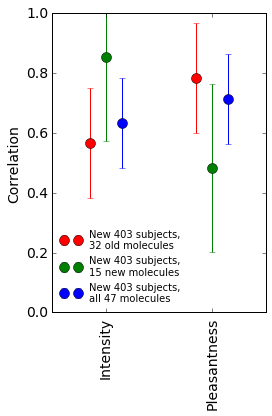

In [232]:
# 25 x 30
import matplotlib as mpl
mpl.rcParams.update({'font.size':14})
#plt.errorbar(range(21),rs_in.mean(axis=1),yerr=rs_in.std(axis=1)/np.sqrt(n_splits),color='k',fmt='o-',label='Original 49 subjects')
#plt.errorbar(range(21),rs_out.mean(axis=1),yerr=rs_out.std(axis=1)/np.sqrt(n_splits),color='r',fmt='o-',label='New 403 subjects')
#plt.plot(range(2),rs['old_old'],'ko-',label='Original 49 subjects, 32 old molecules')
plt.figure(figsize=(4,6))
plt.errorbar(np.arange(2)-0.15,rs['old_new'],yerr=np.tanh(1/np.sqrt(32-3)),color='r',marker='o',linestyle='',markersize=10,label='New 403 subjects,\n32 old molecules')
plt.errorbar(np.arange(2),rs['new_new'],yerr=np.tanh(1/np.sqrt(15-3)),color='g',marker='o',linestyle='',markersize=10,label='New 403 subjects,\n15 new molecules')
plt.errorbar(np.arange(2)+0.15,rs['new'],yerr=np.tanh(1/np.sqrt(47-3)),color='b',marker='o',linestyle='',markersize=10,label='New 403 subjects,\nall 47 molecules')
plt.xlim(-0.5,1.5)
plt.ylim(0,1)
plt.xticks(range(2),['Intensity','Pleasantness'],rotation=90);
plt.ylabel('Correlation')
plt.legend(fontsize=10,loc=3,frameon=0)
plt.tight_layout()
plt.savefig('/Users/rgerkin/Desktop/new_predictions_andreas.eps',format='eps')